# Practica #8

## Fecha de entrega: 22 de noviembre de 2023

### Reconocimiento facial

Utilizando la siguiente arquitectura:

```python
class NN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1, progress=True)
        for param in self.model.parameters():
            param.requires_grad = False
         
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  
            nn.ReLU(inplace=True),   
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)


```

Entrenar una red neuronal que pueda clasificar imágenes en las siguientes clases:

- Danilo Medina
- Hipolito Mejia
- Luis Abinader
- Leonel Fernandez
- Gonzalo Castillo
- Desconocido

Las etiquetas deben respetar ese orden, Danilo Medina=0, Hipolito Mejia=1, Luis Abinader=2, Leonel Fernandez=3, Gonzalo Castillo=4, Desconocido=5.

Lo que usted subirá a la plataforma es únicamente el modelo en formato safetensors, con su nombre y matricula como nombre del modelo.

No pueden repetir modelos, los modelos iguales tendrán 0 de nota.

Si usan un formato diferente o cambian la arquitectura valdrá 0.

No incumpliendo estos puntos su nota dependerá del acuracy alcanzado con su modelo, por lo que esfuércese con la recolección de datos y entrenamiento de su modelo y vera las recompensas.

# Codigo

In [ ]:
%pip install torch torchvision datasets matplotlib pandas tqdm safetensors bing_image_downloader

In [ ]:
from bing_image_downloader import downloader
import os
import shutil

categorias = ["Danilo Medina", "Hipolito Mejia", "Luis Abinader", "Leonel Fernandez", "Gonzalo Castillo", "Desconocido icono"]
output_dir = "/content/imagenes"

# Crear las carpetas numeradas
for i, categoria in enumerate(categorias):
    categoria_path = os.path.join(output_dir, str(i))
    if not os.path.exists(categoria_path):
        os.makedirs(categoria_path)

# Descargar imágenes en carpeta temporal
temp_dir = os.path.join(output_dir, "temp")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

for categoria in categorias:
    try:
        downloader.download(categoria, limit=10, output_dir=temp_dir, adult_filter_off=True, force_replace=False)

        # Mover imágenes a las carpetas correspondientes
        temp_categoria_path = os.path.join(temp_dir, categoria)
        for imagen in os.listdir(temp_categoria_path):
            imagen_path = os.path.join(temp_categoria_path, imagen)
            shutil.move(imagen_path, os.path.join(output_dir, str(categorias.index(categoria))))
    except Exception as e:
        print(f"Error al descargar {categoria}: {e}")

# Eliminar la carpeta temporal si está vacía
if os.path.exists(temp_dir) and not os.listdir(temp_dir):
    os.rmdir(temp_dir)


In [49]:
from PIL import Image
import pandas as pd
from datasets import load_dataset

# Cargar y preparar el conjunto de datos
dataset = load_dataset("imagefolder", data_dir="/content/imagenes", split="train")
dataset = dataset.shuffle()
df = pd.DataFrame(dataset)

# Mostrar información de una entrada para entender la estructura
print(df.iloc[4]['image'])

# Visualizar directamente la imagen PIL
imagen = df.iloc[4]['image']
imagen.resize((256, 256)).show()


Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x900 at 0x7CCC6948A9E0>


In [50]:
from datasets import load_dataset
from PIL import Image
import pandas as pd
# Asumiendo que 'imagenes' contiene subcarpetas '0', '1', '2', etc., para cada categoría
dataset = load_dataset("imagefolder", data_dir="/content/imagenes", split="train")

# Mezclamos aleatoriamente los datos
dataset = dataset.shuffle()

# Convertimos a Pandas DataFrame
# El DataFrame tendrá columnas como 'image' (ruta a la imagen) y 'label' (etiqueta de la categoría)
df = pd.DataFrame(dataset)

# Mostramos las primeras filas del DataFrame
print(df.head())

# Seleccionamos aleatoriamente el 80% de los datos para el conjunto de entrenamiento
train = df.sample(frac=0.8, random_state=1)

# El conjunto de prueba es el resto de los datos
test = df.drop(train.index)

# Visualizamos una imagen del conjunto de datos
# Asegúrate de que la columna y el índice coincidan con tu DataFrame
imagen = df.iloc[4]['image']
print(f"Tipo de objeto de imagen: {type(imagen)}")
imagen.show()


Resolving data files:   0%|          | 0/57 [00:00<?, ?it/s]

                                               image  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...      3
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...      3
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...      2
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...      3
Tipo de objeto de imagen: <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [51]:
from torchvision import transforms

# Definimos los valores de media, desviación estándar y tamaño de imagen
media = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
size = 192

# Definimos la transformación para el conjunto de entrenamiento con aumento de datos
train_transform = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.RandomHorizontalFlip(),  # Añadimos un volteo horizontal aleatorio
    transforms.RandomRotation(10),  # Añadimos una rotación aleatoria de ±10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Ajustes aleatorios en brillo y contraste
    transforms.ToTensor(),
    transforms.Normalize(media, std)
])

# La transformación para el conjunto de prueba permanece igual
test_transform = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.ToTensor(),
    transforms.Normalize(media, std)
])


In [52]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Directamente obtener el objeto de imagen PIL y la etiqueta
        imagen = self.dataframe.iloc[idx]['image']
        etiqueta = self.dataframe.iloc[idx]['label']

        # Convertir la imagen a RGB si no lo está
        if imagen.mode != 'RGB':
            imagen = imagen.convert('RGB')

        # Aplicar transformaciones, si se proporcionaron
        if self.transform:
            imagen = self.transform(imagen)

        return imagen, etiqueta

# Crear instancias de CustomDataset para los conjuntos de entrenamiento y prueba
train_dataset = CustomDataset(train, transform=train_transform)
test_dataset = CustomDataset(test, transform=test_transform)

# Obtener la primera imagen y su etiqueta del conjunto de entrenamiento
imagen, etiqueta = train_dataset[0]

# Mostrar la forma de la imagen y su etiqueta
print(imagen.shape, etiqueta)

torch.Size([3, 192, 192]) 1


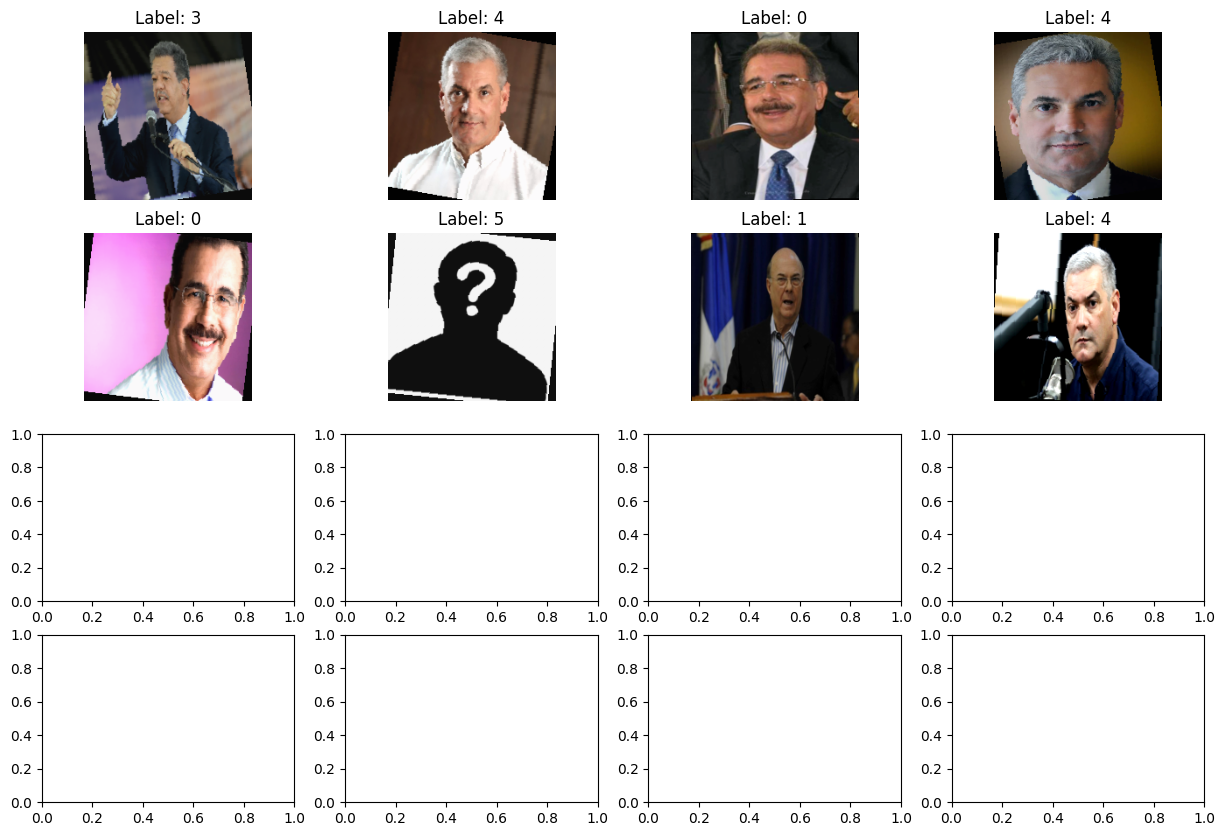

In [53]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torch

# Definimos el tamaño del lote (batch size) como 8
bs = 8

# Creamos objetos DataLoader para los conjuntos de entrenamiento y prueba
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Obtenemos un lote de datos de entrenamiento
images, labels = next(iter(train_dataloader))

# Definimos la cantidad de imágenes que se mostrarán, así como el número de filas y columnas en la figura
cantidad = 20
filas = 4
columnas = 4

# Función para desnormalizar las imágenes
def desnormalizar(tensor):
    for t, m, s in zip(tensor, media, std):
        t.mul_(s).add_(m)  # Multiplicamos por la desviación estándar y sumamos la media
    return tensor

# Creamos una figura con subfiguras
fig, axs = plt.subplots(filas, columnas, figsize=(15, 10))
for i in range(filas):
    for j in range(columnas):
        img_idx = i * columnas + j
        if img_idx >= bs:  # Verificar si el índice de la imagen excede el tamaño del lote
            break
        img = desnormalizar(images[img_idx])
        img = img.numpy().transpose((1, 2, 0))
        axs[i, j].imshow(img)
        axs[i, j].set_title(f'Label: {labels[img_idx].item()}')
        axs[i, j].axis('off')

plt.show()


In [57]:
from torchvision import models
from torch import nn

class NN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1, progress=True)
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Creamos un objeto de la clase NN con 6 clases
modelo = NN(num_classes=6)

batch_size = 4

# Asegúrate de que el modelo esté en modo de entrenamiento o evaluación según corresponda
modelo.train()  # o modelo.eval() si estás evaluando

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
btest = next(iter(test_loader))

# Pasamos un lote de datos de entrenamiento al modelo y obtenemos la salida
# Asegúrate de que btest[0] contenga imágenes en el formato adecuado
salida = modelo(btest[0])


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

# Creación del dispositivo que utiliza GPU si está disponible, de lo contrario CPU
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo utilizado:", dispositivo)

# Definición de la tasa de aprendizaje y número de épocas
lr = 3e-3
epocas = 4

# Creación de un objeto de la clase NN con 6 clases y moviéndolo al dispositivo
modelo = NN(num_classes=6)
modelo.to(dispositivo)

# Definición de la función de pérdida y el optimizador
funciondeperdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)

# Definición de listas para almacenar métricas de entrenamiento y prueba
perdidas_train, perdidas_test = [], []
error_train, error_test = [], []
Acuracy_train, Acuracy_test = [], []


Dispositivo utilizado: cpu


In [61]:
from tqdm import tqdm
# Iteramos sobre el número de épocas especificado
for epoca in (range(epocas)):
    # Ponemos el modelo en modo de entrenamiento
    modelo.train()

    # Inicializamos las variables de pérdida, precisión y error para el conjunto de entrenamiento
    perdida_train = 0
    acuracy_train = 0
    error  = 0

    # Iteramos sobre los lotes de datos de entrenamiento
    for imagenes, etiquetas in tqdm(train_dataloader):
        # Movemos los datos al dispositivo especificado
        imagenes = imagenes.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        # Reiniciamos los gradientes del optimizador
        optimizador.zero_grad()

        # Hacemos una predicción con el modelo
        predicciones = modelo(imagenes)

        # Calculamos la pérdida
        perdida = funciondeperdida(predicciones, etiquetas )

        # Calculamos los gradientes y actualizamos los parámetros del modelo
        perdida.backward()
        optimizador.step()

        # Calculamos la precisión y el error para el lote actual
        _, predicciones = torch.max(predicciones, 1)
        perdida_train += perdida.item()
        acuracy_train += torch.sum(predicciones == etiquetas).item() / len(etiquetas)
        error += torch.sum(predicciones != etiquetas).item() / len(etiquetas)

    # Calculamos la pérdida, precisión y error promedio para el conjunto de entrenamiento
    perdida_train /= len(train_dataloader)
    acuracy_train /= len(train_dataloader )
    error /= len(train_dataloader )

    # Almacenamos las métricas de entrenamiento en las listas correspondientes
    perdidas_train.append(perdida_train)
    Acuracy_train.append(acuracy_train)
    error_train.append(error)

    # Ponemos el modelo en modo de evaluación
    modelo.eval()

    # Inicializamos las variables de pérdida, precisión y error para el conjunto de prueba
    perdida_test = 0
    acuracy_test = 0
    error  = 0

    # Iteramos sobre los lotes de datos de prueba
    for imagenes, etiquetas in tqdm(test_dataloader):
        # Movemos los datos al dispositivo especificado
        imagenes = imagenes.to(dispositivo)
        etiquetas = etiquetas.to(dispositivo)

        # Desactivamos el cálculo de gradientes para acelerar la inferencia
        with torch.no_grad():
            # Hacemos una predicción con el modelo
            predicciones = modelo(imagenes)

            # Calculamos la pérdida
            perdida = funciondeperdida(predicciones, etiquetas )
            perdida_test += perdida.item()

            # Calculamos la precisión y el error para el lote actual
            _, predicciones = torch.max(predicciones, 1)
            acuracy_test += torch.sum(predicciones == etiquetas).item() / len(etiquetas)
            error+= torch.sum(predicciones != etiquetas).item() / len(etiquetas)

    # Calculamos la pérdida, precisión y error promedio para el conjunto de prueba
    perdida_test /= len(test_dataloader )
    acuracy_test /= len(test_dataloader )
    error /= len(test_dataloader )

    # Almacenamos las métricas de prueba en las listas correspondientes
    perdidas_test.append(perdida_test)
    Acuracy_test.append(acuracy_test)
    error_test.append(error)

    # Imprimimos las métricas de entrenamiento y prueba para la época actual
print(f"\n\nEpoca {epoca+1}/{epocas}, perdida train: {perdidas_train[-1]}, perdida test: {perdidas_test[-1]}, acuracy train: {Acuracy_train[-1]}, acuracy test: {Acuracy_test[-1]}, error train: {error_train[-1]}, error test: {error_test[-1]}")

print("\n")
# Imprimir las métricas de entrenamiento y prueba para la época actual
print(f"Epoca {epoca + 1}/{epocas}, "
      f"Perdida Train: {perdidas_train[-1]:.4f}, "
      f"Perdida Test: {perdidas_test[-1]:.4f}, "
      f"Acuracy Train: {Acuracy_train[-1] * 100:.2f}%, "
      f"Acuracy Test: {Acuracy_test[-1] * 100:.2f}%, "
      f"Error Train: {error_train[-1] * 100:.2f}%, "
      f"Error Test: {error_test[-1] * 100:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  2.78it/s]



Epoca 4/4, perdida train: 1.4085980852444966, perdida test: 1.6644207835197449, acuracy train: 0.5069444444444444, acuracy test: 0.41666666666666663, error train: 0.4930555555555556, error test: 0.5833333333333333


Epoca 4/4, Perdida Train: 1.4086, Perdida Test: 1.6644, Acuracy Train: 50.69%, Acuracy Test: 41.67%, Error Train: 49.31%, Error Test: 58.33%


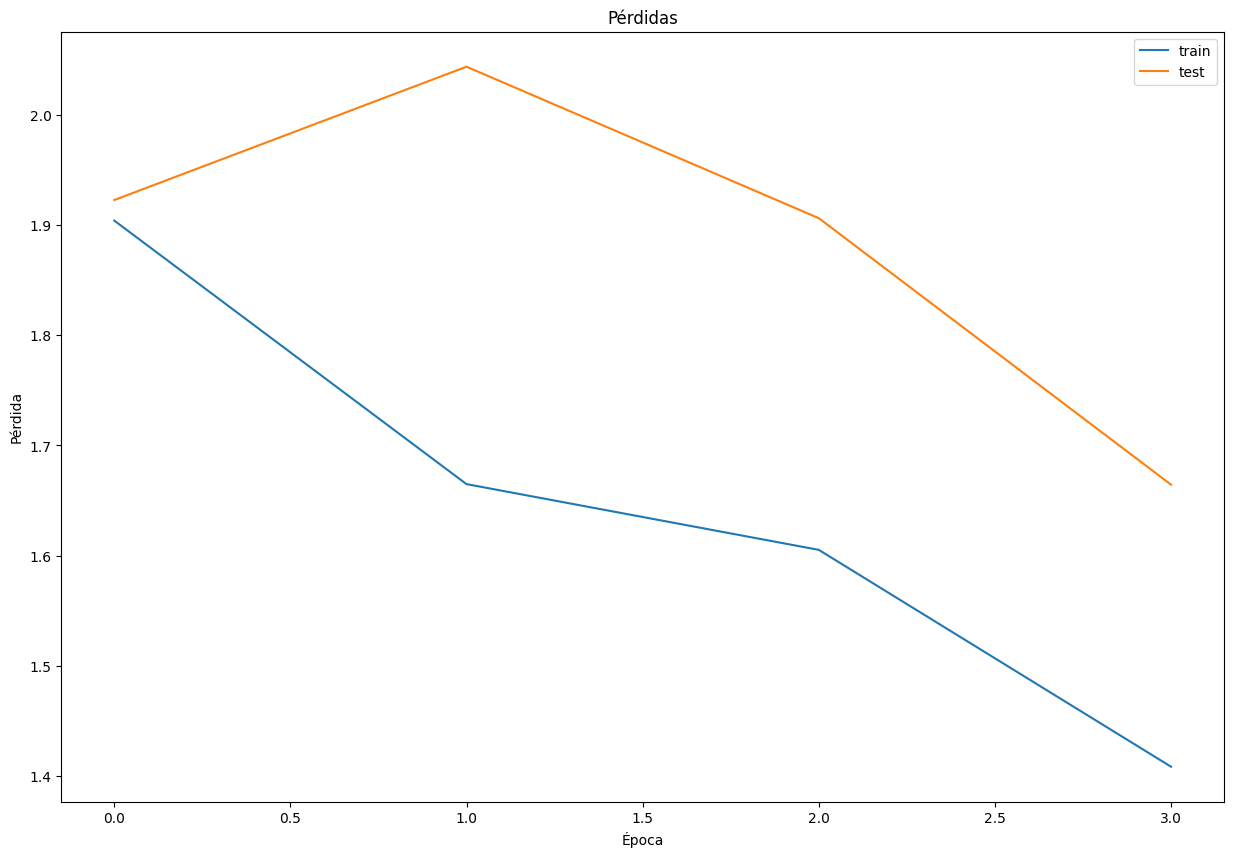

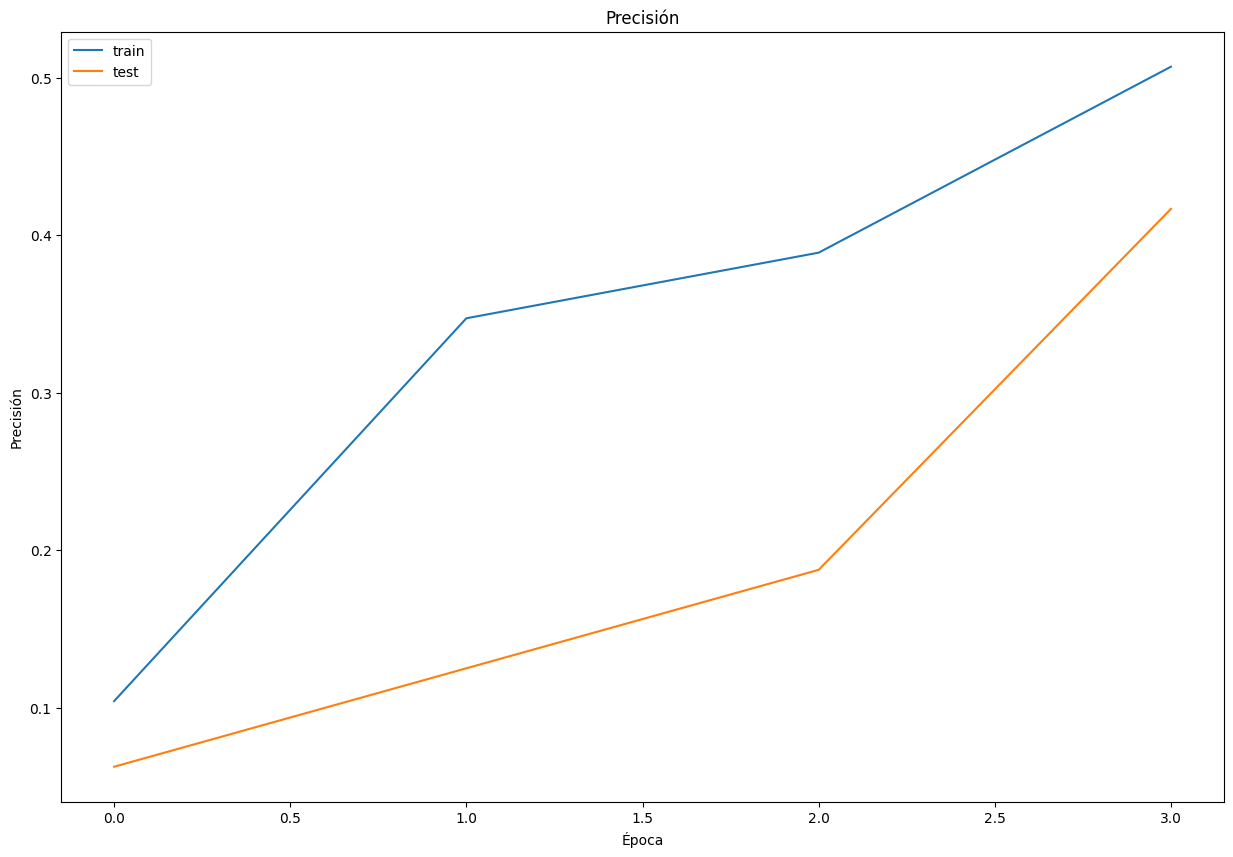

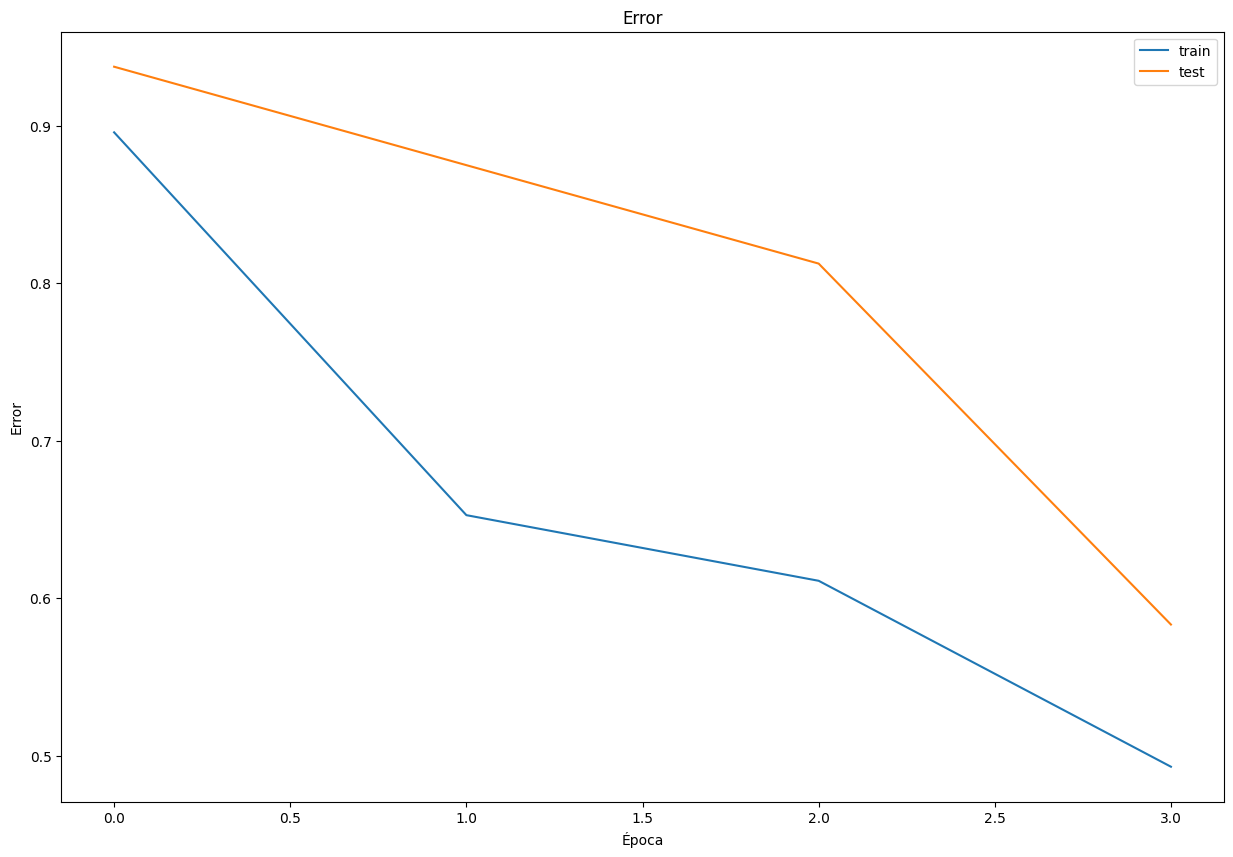

In [62]:
import matplotlib.pyplot as plt

# Gráfica de pérdidas
plt.figure(figsize=(15, 10))
plt.plot(perdidas_train, label='train')
plt.plot(perdidas_test, label='test')
plt.legend()
plt.title('Pérdidas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Gráfica de precisión
plt.figure(figsize=(15, 10))
plt.plot(Acuracy_train, label='train')
plt.plot(Acuracy_test, label='test')
plt.legend()
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.show()

# Gráfica de error
plt.figure(figsize=(15, 10))
plt.plot(error_train, label='train')
plt.plot(error_test, label='test')
plt.legend()
plt.title('Error')
plt.xlabel('Época')
plt.ylabel('Error')
plt.show()


In [48]:
import requests
from PIL import Image
import random
import torch

# Lista de URLs de imágenes
urls = [
    "https://forointernacionalsd.funglode.org/wp-content/uploads/2021/11/LeonelFernandez.jpeg",
    "https://e00-expansion.uecdn.es/assets/multimedia/imagenes/2020/08/16/15975940818315.jpg",
    "https://politicosenlared.com/pr/wp-content/uploads/2019/08/Rafael-Hip%C3%B3lito-Mej%C3%ADa-Dom%C3%ADnguez-722x660.jpg",
    "https://pbs.twimg.com/profile_images/765579093995692034/pQr9wmf-_400x400.jpg",
    "https://www.amcham.org.do/images/Gonzalo-Mediana.jpg",
    "https://www.elcaribe.com.do/wp-content/uploads/2021/05/79cb94e5-trujillo-molina-60b1a3ea1caf1.jpg"
]

# Elegir una URL aleatoria de la lista
url = random.choice(urls)

try:
    # Descargar la imagen de la URL y abrirla con la clase Image de PIL
    response = requests.get(url, stream=True)
    response.raise_for_status()
    imagen = Image.open(response.raw)

    # Aplicar la transformación de prueba a la imagen y convertirla en un tensor
    imag = test_transform(imagen).unsqueeze(0)

    # Hacer una predicción con el modelo utilizando la imagen transformada
    with torch.no_grad():
        modelo.eval()  # Asegurarse de que el modelo está en modo de evaluación
        pred = modelo(imag.to(dispositivo))
        result = torch.softmax(pred, dim=1)[0]
        indice = torch.argmax(result)
        confianza = result[indice] * 100

        # Mostrar la imagen y el índice resultante
        imagen.resize((192, 192)).show()
        print(f"Índice: {indice.item()} - Confianza: {confianza:.2f}%")

except requests.RequestException as e:
    print(f"Error al descargar la imagen: {e}")


Índice: 2 - Confianza: 41.33%


In [47]:
from safetensors.torch import save_model, load_model

# Guardar el modelo
save_model(modelo, "Christian_Zorrilla_Gonzalez(21-SISN-2-070).safetensors")

# Instanciar un nuevo modelo con el número correcto de clases
modelo_cargado = NN(num_classes=6)  # Asegúrate de que num_classes sea el correcto

# Cargar el modelo guardado
load_model(modelo_cargado, "Christian_Zorrilla_Gonzalez(21-SISN-2-070).safetensors")


(set(), [])